In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Read the dataset
dataframe = pd.read_csv("breast_cancer_dataset.csv")
raw_data = dataframe.values
dataframe.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# The last column contains the labels
labels = raw_data[:, -1]

# The other columns consist of features
data = raw_data[:, 0:-1]

In [4]:
# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=7)

train_data = MinMaxScaler().fit_transform(train_data)
test_data = MinMaxScaler().fit_transform(test_data)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [5]:
# Differentiate between benign (normal) and malignant (anomalous) datasets
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [6]:
# Define an anomaly detector model as an autoencoder
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(30, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [7]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='MAE')

In [8]:
# Train the autoencoder on the normal dataset
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=16,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/20
11/11 [==============================] - 0s 22ms/step - loss: 0.2163 - val_loss: 0.1930
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2060 - val_loss: 0.1831
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1798 - val_loss: 0.1767
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1489 - val_loss: 0.1798
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1270 - val_loss: 0.1646
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1179 - val_loss: 0.1654
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1130 - val_loss: 0.1603
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1110 - val_loss: 0.1593
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1093 - val_loss: 0.1604
Epoch 10/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1078 - val_loss: 0.1552
Epoch 11/20
11/11 

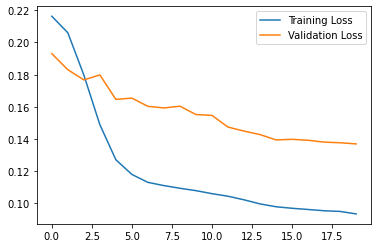

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [10]:
# Compute reconstruction error of normal test data
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.MAE(reconstructions, normal_test_data)

In [11]:
# Our ansatz for threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.19446066


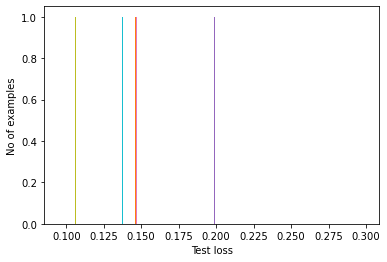

In [12]:
# Compute reconstruction error of anomalous test data
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.MAE(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [13]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.MAE(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [14]:
# Evaluate performance

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.5701754385964912
Precision = 0.6344086021505376
Recall = 0.7972972972972973


In [20]:
# Evaluate performance based on a different threshold

preds = predict(autoencoder, test_data, 1.3*threshold)
print_stats(preds, test_labels)

Accuracy = 0.6578947368421053
Precision = 0.6605504587155964
Recall = 0.972972972972973
